In [1]:
#importing libraries 
import os
import librosa, librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pathlib
import sklearn
import csv
import numpy as np
import warnings
from PIL import Image

warnings.filterwarnings('ignore')

In [6]:
#EASY MODIFICATIONS 
POS_PATH = r"data/positive"
NEG_PATH = r"data/negative"
BASE_PATH = r"/Users/Eric/Documents/Python/Projects/ML/COVID_Cough/data/"

## Organizing the data

In [123]:
#function for defining our data 

def prep_organize_data(POS_PATH, NEG_PATH, BASE_PATH): 

    #our data :-> Positive 
    pos_files = os.listdir(POS_PATH)
    base_path_pos = BASE_PATH + 'positive/'
    pos_data = [base_path_pos+x for x in pos_files]

    #our data :-> Negative
    neg_files = os.listdir(NEG_PATH)
    base_path_neg = BASE_PATH + 'negative/'
    neg_data = [base_path_neg+x for x in neg_files]

    #number of samples 
    tot_samples = len(neg_data) + len(pos_data)

    #fraction of samples 
    frac_pos = ((len(pos_data) / tot_samples)*100)
    frac_neg = ((len(neg_data) / tot_samples)*100)
    

    print(f"Number of Negative samples: {len(neg_data)} ({frac_neg:.2f}%)")
    print(f"Number of Positive samples: {len(pos_data)} ({frac_pos:.2f}%)\n")
    print(f"**** Total samples: {tot_samples} ****")
    
    return pos_files, pos_data, neg_files, neg_data

pos_files, pos_data, neg_files, neg_data = prep_organize_data(POS_PATH, NEG_PATH, BASE_PATH)

Number of Negative samples: 37 (7.91%)
Number of Positive samples: 431 (92.09%)

**** Total samples: 468 ****


## Cleaning the dataframe

In [6]:
#columns for dataframe
cols = ["ID", "Result", "Age", "Gender", "Date", "Extra"]

#creating the dataframe
df_neg = pd.DataFrame([x.split("_") for x in neg_files])
df_pos = pd.DataFrame([x.split("_") for x in pos_files])

#joining and cleaning of datatypes
df_all = df_neg.append(df_pos)
df_all.columns = cols
df_all.drop(["Extra", "Date"],axis=1, inplace=True)
df_all['ID'] = df_all['ID'].astype('int')
df_all['Age'] = df_all['Age'].astype('int')

## Exploring the dataframe 

In [7]:
def plotting_dfs():
    a = sns.catplot(x='Result', y='Age', col='Gender', data=df_all, alpha=0.5)
    plt.subplots_adjust(top=0.9)
    a.fig.suptitle("Figure 1. COVID-19 Testing by Age and Gender");
    #plt.savefig("./img/Fig1_SwarmPlot_Result_Age_Gender.png")
    plt.figure()
    sns.barplot(x='Result', y='Age', data=df_all);
    plt.title("Figure 2. COVID-19 Result by Age")
    #plt.savefig("./img/Fig2_Barplot_Result_Age.png")

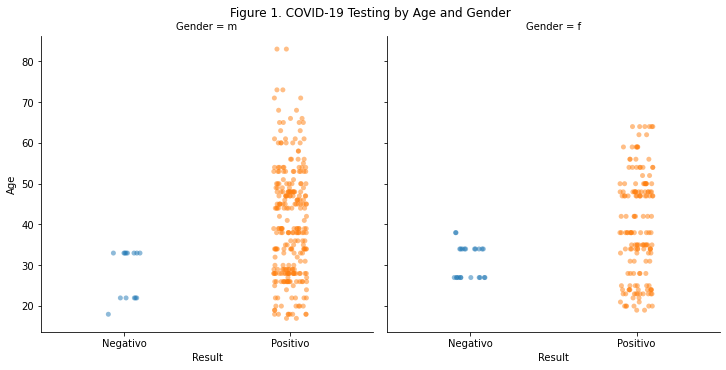

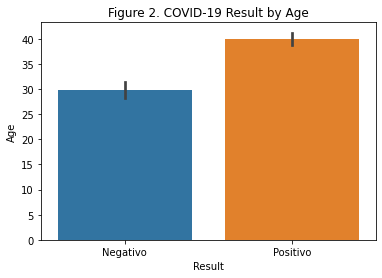

In [8]:
plotting_dfs()

## Working with audio (examples)

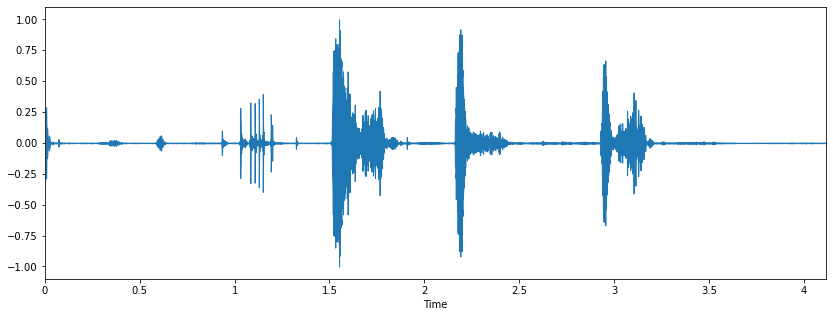

In [9]:
#Working with audio --> Returns np array of audio 
x, sr = librosa.load(neg_data[4],sr = 44100)
#y, sr1 = librosa.load(pos_data[4], sr=44100) #visualize a positive_data point for comparisson 

#Visualizing the audio 
plt.figure(figsize=(14,5))
librosa.display.waveplot(x, sr=sr);

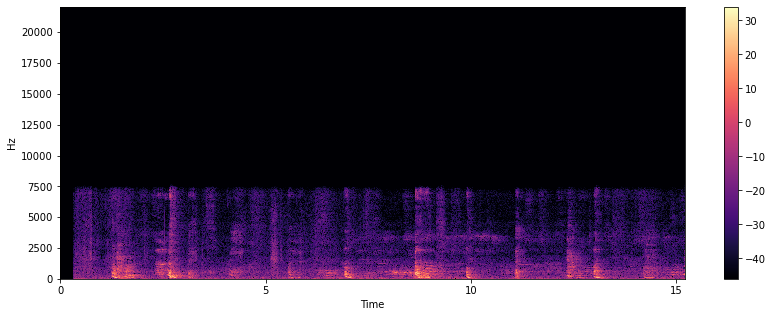

In [10]:
#spectrogram -> heatmap, strength of signal over time 
x, sr = librosa.load(pos_data[4],sr = 44100)
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14,5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar();
#plt.savefig("./img/Fig3_Spectrogram_582.png")

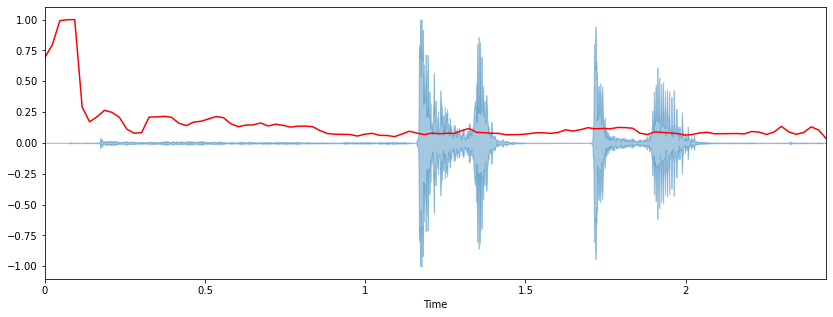

In [11]:
#Spectral Centroid -> frequency at which energy of a spectrum is centered upon. Similar to a weighted mean

x, sr = librosa.load(pos_data[6],sr = 44100)
spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]
plt.figure(figsize=(14, 5))
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)

#normalize the data 
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='r');

## Utils

In [ ]:
# -> Util 
#creating a function to create spectrograms for all the samples 
def spectrogram_from_wav():
    results = ['positive', 'negative']
    for res in results: 
        pathlib.Path(f"spectrograms/{res}").mkdir(parents=True, exist_ok=True)
        for files in os.listdir(f"data/{res}"):
            filename = f"data/{res}/{files}"
            x, sr = librosa.load(filename, mono=True)
            plt.specgram(x, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap='inferno', sides='default', mode='default', scale='dB');
            plt.axis('off');
            plt.savefig(f"./img/spectrograms/{res}/{files[:-4]}.png")
            plt.clf()

In [ ]:
#run once!
#spectrogram_from_wav()

In [ ]:
# -> Util
#writing the data to a CSV
def write_to_csv(filename='covid_dataset.csv'):
    
    #Create the header for the CSV File 
    header = 'filename ID chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
    for x in range(1, 21):
        header += f" mfcc{x}"
    header += ' label'
    header = header.split()
    #create and write to file
    file = open(filename, 'w', newline="")
    with file: 
        writer = csv.writer(file)
        writer.writerow(header)
    results = ['positive', 'negative']
    for res in results: 
        for files in os.listdir(f"data/{res}"):
            patient_id = files.split("_")[0]
            filename = f"data/{res}/{files}"
            x, sr = librosa.load(filename, mono=True)
            rmse = librosa.feature.rms(y=x)
            chroma_stft = librosa.feature.chroma_stft(y=x, sr=sr)
            spec_cent = librosa.feature.spectral_centroid(y=x, sr=sr)
            spec_bw = librosa.feature.spectral_bandwidth(y=x, sr=sr)
            rolloff = librosa.feature.spectral_rolloff(y=x, sr=sr)
            zcr = librosa.feature.zero_crossing_rate(x)
            mfcc = librosa.feature.mfcc(y=x, sr=sr)
            to_append = f'{filename} {patient_id} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
            for k in mfcc:
                to_append += f' {np.mean(k)}'
            to_append += f' {res}'
            file = open(filename, 'a', newline='')
            with file:
                writer = csv.writer(file)
                writer.writerow(to_append.split())

In [83]:
#usefule module to split folders into train-val
import splitfolders
splitfolders.ratio(specs, output="./spec_data", 
                   seed=1337, ratio=RATIO)

Copying files: 468 files [00:01, 371.22 files/s]


In [84]:
#image data augmentation
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
train_data = ImageDataGenerator(rescale=rescale_fac, 
                                shear_range=0.25,
                                zoom_range=0.2,
                                horizontal_flip=True)

test_data = ImageDataGenerator(rescale=rescale_fac)

#Creating a tf.dataset from the two directories 
# spec_data/train and spec_data/val

#first the training set 
train_set = train_data.flow_from_directory("./spec_data/train",
                                        target_size=TAR_SIZE,
                                        batch_size=BATCH_SIZE,
                                        class_mode="binary",
                                        shuffle=False)
#now the test set
test_set = test_data.flow_from_directory("./spec_data/val",
                                         target_size=TAR_SIZE,
                                         batch_size=BATCH_SIZE,
                                         class_mode="binary",
                                         shuffle=False)

Found 373 images belonging to 2 classes.
Found 95 images belonging to 2 classes.


It is worth nothing that the following paper: 
https://arxiv.org/pdf/1904.03392.pdf

Has a different set up for the model for CNN's in order to increase efficiency! 

We can try it out afterwards!